In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits
#import multiprocessing as mp
#import copy
#import datetime

In [63]:
def gen_obs():
    for args_inst in args_list:
        filt, mask, pupil = args_inst
        print(args_inst)

        bp = nrc_utils.read_filter(filt)
        #print(filt)
        if mask is None:
            #subsize = 320 if bp.avgwave()<24000 else 160
            subsize = 160
        else:
            subsize = 640 if '210R' in mask else 320
        
        #args_model = (None, 0.007, dist, 1.6, 'mJy/arcsec^2')
        kwargs = {'dist_out':dist, 'sptype':sptype, 'star_kmag':kmag}
        
        #print(subsize)
        
        m = 'none' if mask is None else mask
        p = 'none' if pupil is None else pupil
        key = '{}_{}_{}'.format(filt,m,p)
        try: obs_old = obs_dict[key]
        except: obs_old = None

        obs = pynrc.observe_star(args_inst, subsize=subsize, obs=obs_old, **kwargs)
        
        obs_dict[key] = obs
        print('')
        
def do_exp():
    # Update detector integration times
    args_210 = ('RAPID',10,43)
    args_335 = ('SHALLOW4', 10, 70)
    args_430 = ('DEEP8', 10, 18)
    args_W   = ('RAPID', 6, 180)
    args_M   = ('RAPID', 10, 108*4)
    
    for i, k in enumerate(filt_keys):
        print(k)
        obs = obs_dict[k]
        m='none' if obs.mask is None else obs.mask
        
        if '210R' in m:
            rm, ng, nint = args_210
        elif '335R' in m:
            rm, ng, nint = args_335
        elif '430R' in m:
            rm, ng, nint = args_430
        elif 'W' in k: # Wide Band imaging
            rm, ng, nint = args_W
        else: # Medium Band Imaging
            rm, ng, nint = args_M
            
        #rm, ng, nint = ('RAPID', 2, 500)

        v = True if i==0 else False
        obs.update_detectors(read_mode=rm, ngroup=ng, nint=nint, verbose=v)
        obs.obs_images(wfe_drift=10, verbose=True)
        if obs.mask is None: sens = obs.sensitivity(units='vegamag', nsig=1, verbose=True)
        print('')

#import matplotlib.patches as patches
def plot_contrast(key, nsig=5, age=10, entropy=10, xlim=None, ylim=None, ax=None, maglim=False):

    wfe_list = [0,1,2,5,10]
    
    pal1 = (sns.color_palette("deep", n_colors=5))[::-1]
    pal2 = (sns.color_palette("dark", n_colors=5))[::-1]
    blues = (sns.color_palette("Blues_d", n_colors=len(wfe_list)))[::-1]

    # Conrast curves for varying WFE
    #nsig=5
    #age = 10
    #entropy = 13
    
    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")

    obs = obs_dict[key] #key_keys[0]]
    con_dict = {}
    for wfe in wfe_list:
        rr, con = obs.get_contrast(wfe_drift=wfe, maglim=maglim, nsig=nsig)
        con_dict[wfe] = con

    # Flux contrast for various planet masses with range of Av
    mass_list = [15,10,5,1]
    pcon = np.zeros([len(mass_list)])
    for i,m in enumerate(mass_list):
        flux = obs.planet_flux(mass=m, age=age, entropy=entropy, atmo='hy1s')
        pcon[i] = flux/obs.hdu_image.max()
        if maglim: pcon[i] = obs.star_flux('vegamag') - 2.5*np.log10(pcon[i])
            
    # HR8799 planet magnitudes
    planet_dist = np.array([1.72, 0.95, 0.66, 0.4])
    if 'F356W' in obs.filter:
        planet_mag = np.array([15.6, 14.7, 14.5, 14.5])
    elif 'F444W' in obs.filter:
        planet_mag = np.array([16.0, 15.0, 14.6, 14.7])
    elif 'F200W' in obs.filter:
        planet_mag = np.array([14.2, 13.2, 13.2, 13.1])
    if not maglim: planet_mag = 10**((obs.star_flux('vegamag') - planet_mag) / 2.5)
        
    ax.plot(planet_dist, planet_mag, marker='o', ls='None', color='black')


    if xlim is None:
        xlim = [0,5.1]

    # Plot all contrast curves
    ax_plot = ax.plot if maglim else ax.semilogy
    if ax is None: fig,ax = plt.subplots(1,1, figsize=(10, 5))
    for i,wfe in enumerate(wfe_list[::-1]):
        ax_plot(rr, con_dict[wfe], color=blues[i], label='WFE Drift = {} nm'.format(wfe))

    # Plot the rectangular regions
    for i,m in enumerate(mass_list):
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        ax.plot(xlim, [pcon[i]]*2, color=pal2[i], ls='--', lw=2, label=label)
    ax.legend(ncol=2)

    if ylim is not None: ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.minorticks_on()

    age_str = 'Age = {} Myr'.format(age)
    dist_str = 'Distance = {} pc'.format(dist)
    ent_str = entropy_string + ' Start' #Entropy = {}'.format(entropy)

    ax.set_title('{}; {}; {}; {}'.format(obs.filter,ent_str,age_str,dist_str))
    #ax.set_ylabel('{}-sigma Contrast'.format(nsig))
    #ax.set_xlabel('Separation (arcsec)')
    
def gen_plots(save_fig=False):
    
    nkey = len(filt_keys)
    fig,axes = plt.subplots(nkey,2, figsize=(14,4*nkey))

    entropy_list = [13,8]
    nsig=5

    xlim=[0,5.1]
    ylim=[25,5] #[1e-7,1e-2]

    for j,key in enumerate(filt_keys):

        for i,ax in enumerate(axes[j].flatten()):
            plot_contrast(key, nsig=nsig, age=age, entropy=entropy_list[i], 
                          ax=ax, ylim=ylim, xlim=xlim, maglim=True)
            ax.set_xlabel('Separation (arcsec)')
            #if i==0: ax.set_ylabel('{}-sigma Contrast'.format(nsig))
            if i==0: ax.set_ylabel('{}-sigma Sensitivites (mag)'.format(nsig))
            if i>0: ax.set_yticklabels([])
            if j<len(filt_keys)-1: ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.90, bottom=0.1 , left=0.05, right=0.97)
    texp = obs_dict[filt_keys[0]].multiaccum_times['t_exp']
    fig.suptitle('{} Contrast (t_exp = {:.0f} sec)'.format(source,texp), fontsize=16);
    
    if save_fig: fig.savefig(outdir+source+'.pdf')

In [7]:
# Argument list: (Name, distance, sptype, age, kmag)
args_sources = [('HR8799', 39.0, 'F0V', 100,  5.24)]

In [8]:
args_list = [('F277W', None, None),
             ('F356W', None, None),
             ('F444W', None, None),
             ('F405N', None, None)]

args_list = [('F200W', 'MASK335R', 'CIRCLYOT'),
             ('F356W', 'MASK335R', 'CIRCLYOT'), 
             ('F444W', 'MASK430R', 'CIRCLYOT')]

#args_list = [('F356W', 'MASK335R', 'CIRCLYOT'), 
#             ('F444W', 'MASK335R', 'CIRCLYOT')]


filt_keys = []
for f,m,p in args_list:
    if m is None: m = 'none'
    if p is None: p = 'none'
    filt_keys.append('{}_{}_{}'.format(f,m,p))
    
obs_dict = {}

In [9]:
source, dist, sptype, age, kmag = args_sources[0]
gen_obs()

('F200W', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F356W', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F444W', 'MASK430R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.



In [11]:
# Print out magnitudes

bp1 = nrc_utils.read_filter('F200W', pupil='MASK335R', mask='CIRCLYOT')
bp2 = nrc_utils.read_filter('F356W', pupil='MASK335R', mask='CIRCLYOT')
bp3 = nrc_utils.read_filter('F444W', pupil='MASK335R', mask='CIRCLYOT')

for (source, dist, sptype, age, kmag) in args_sources:

    sp = nrc_utils.stellar_spectrum(sptype)
    sp_norm = sp.renorm(kmag, 'vegamag', S.ObsBandpass('k'))
    obs1 = S.Observation(sp_norm, bp1, binset=bp1.wave)
    obs2 = S.Observation(sp_norm, bp2, binset=bp2.wave)
    obs3 = S.Observation(sp_norm, bp3, binset=bp3.wave)
    
    print('{:16} {:5.2f} {:5.2f} {:5.2f} {:5.2f}'.format(source, kmag, obs1.effstim('vegamag'), 
                                                 obs2.effstim('vegamag'), obs3.effstim('vegamag')))



HR8799            5.24  5.25  5.21  5.23


In [64]:
do_exp()

F200W_MASK335R_CIRCLYOT
New Ramp Settings:
  read_mode : SHALLOW4
  nf        :        4
  nd2       :        1
  ngroup    :       10
  nint      :       70
New Detector Settings
  wind_mode :   WINDOW
  xpix      :      320
  ypix      :      320
  x0        :     1238
  y0        :     1502
New Ramp Times
  t_group   :    5.345
  t_frame   :    1.069
  t_int     :   52.383
  t_exp     : 3666.807
  t_acq     : 3741.640
Max Flux: 657.3 [497.6] counts/sec
Well Fill: 0.4 [0.3] times full well
SNR Max: 631.7

F356W_MASK335R_CIRCLYOT
Max Flux: 362.9 [348.9] counts/sec
Well Fill: 0.3 [0.2] times full well
SNR Max: 165.9

F444W_MASK430R_CIRCLYOT
Max Flux: 106.7 [97.7] counts/sec
Well Fill: 0.3 [0.3] times full well
SNR Max: 82.3



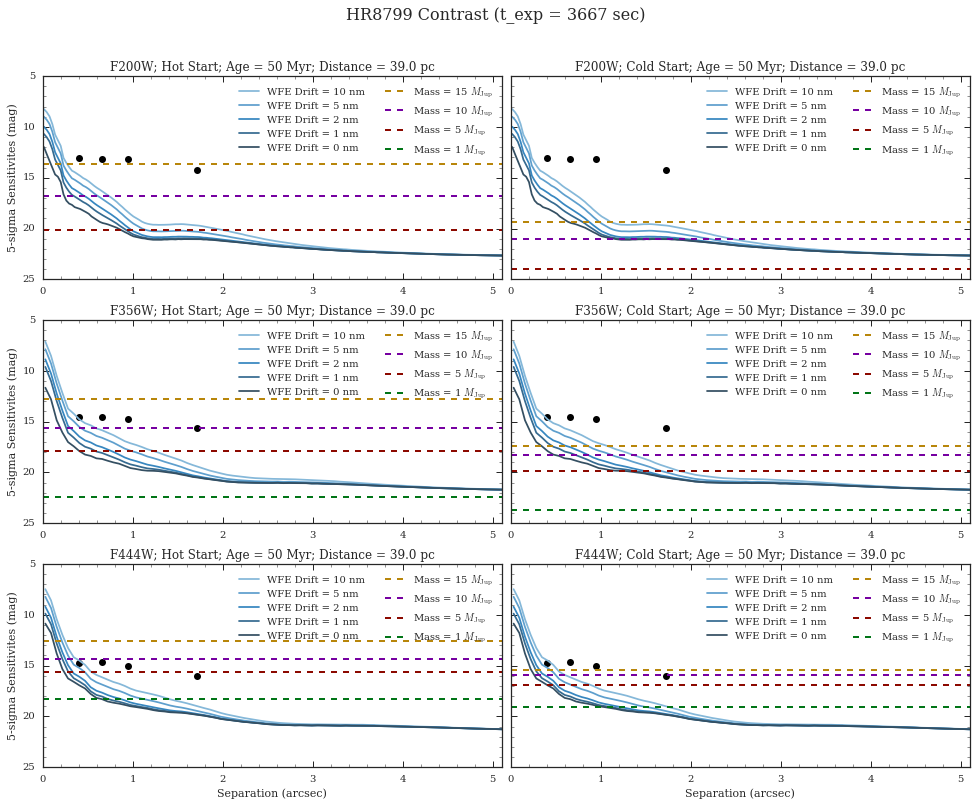

In [65]:
age = 50
gen_plots()

In [48]:
for k in obs_dict.keys():
    obs = obs_dict[k]
    if 'F200W' in k:
        mass_array = [15,15,15,14]
    elif 'F356W' in k:
        mass_array = [13,13,11,10]
    elif 'F444W' in k:
        mass_array = [8,9,9,4]
    obs.add_planet(loc=(0.38, 0.01), loc_units='asec', age=50, entropy=13, mass=mass_array[0])
    obs.add_planet(loc=(0.39, -0.53), loc_units='asec', age=50, entropy=13, mass=mass_array[1])
    obs.add_planet(loc=(0.52, 0.79), loc_units='asec', age=50, entropy=13, mass=mass_array[2])
    obs.add_planet(loc=(-1.57, 0.71), loc_units='asec', age=50, entropy=13, mass=mass_array[3])

In [100]:
def gen_images(save_fig=False):
    wfe_drift = 5
    fov_asec = 6
    
    # Save a series of HDULists for each filter
    hdu_dict1 = {}
    hdu_dict2 = {}
    for k in filt_keys:
        #print(k)
        obs = obs_dict[k]
        hdu_dict1[k] = obs.obs_images(wfe_drift=wfe_drift, scaled=False,  return_oversample=False, verbose=False)
        hdu_dict2[k] = obs.obs_images(wfe_drift=wfe_drift, scaled=True, return_oversample=False, verbose=False)
        
    cmap = sns.cubehelix_palette(start=0, rot=0.5, light=1, as_cmap=True)
    #cmap = 'Greys'
    #cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, hue=0.8, gamma=1.0, as_cmap=True)
    #cmap2 = sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=True,  as_cmap=True)
    #cmap2 = sns.light_palette("purple", as_cmap=True)

    fsub = filt_keys #['F210M', 'F250M', 'F300M', 'F360M','F410M', 'F430M', 'F480M']
    nfilt = len(fsub)
    ext_list = ['FINAL', 'SNR']
    ext_name = ['Simulated Image', 'S/N per Pixel']
    nim = len(ext_list)

    
    fig, axes = plt.subplots(nim,nfilt,figsize=(12,6.5))
    for i,k in enumerate(fsub):
        hdulist1 = hdu_dict1[k]
        hdulist2 = hdu_dict2[k]
        
        rho = hdulist1['RHO'].data

        cen_mask = hdulist1['CEN_MASK'].data
        cen_mask = np.ma.masked_where(cen_mask < 1, cen_mask)

        sat_mask = hdulist1['SAT_MASK'].data
        sat_mask = np.ma.masked_where(sat_mask < 1, sat_mask)
        
        imcoron = 1.0 - hdulist1['CORON'].data
        imcoron -= np.median(imcoron)
        imc_mask = np.ma.masked_where(imcoron <= 0, imcoron)
        for j,ext in enumerate(ext_list):
            hdulist = hdulist1
            ext_temp = ext

            ax = axes[j][i]
            data = hdulist[ext_temp].data
            vmin = 0
            vmax = 30 #data.max()

            im,cbax = webbpsf.display_psf(hdulist, ext, scale='linear', vmin=vmin, vmax=vmax, 
                                   ax=ax, colorbar=True, cmap=cmap, return_ax=True)
            cbax.set_label('')
            #ax.imshow(sat_mask, cmap='coolwarm', extent=im.axis(), vmin=-1, vmax=1, alpha=0.5)
            #ax.imshow(imc_mask, cmap='coolwarm_r', extent=im.axis(), vmin=-1, vmax=1, alpha=0.25)

            ax.set_aspect('equal')
            if i > 0: ax.set_yticklabels([])
            if j < nim-1: ax.set_xticklabels([])

            if j==0: ax.set_title(hdulist[0].header['FILTER'])
            else: ax.set_title('')
                
            if j==nim-1: ax.set_xlabel('Arcsec')
            if i==0: ax.set_ylabel(ext_name[j])
            
            
            if 'HD106906' in source:
                ax.set_xlim([-3,fov_asec/2])
                ax.set_ylim([-3,fov_asec/2])
            else:
                ax.set_xlim([-fov_asec/2,fov_asec/2])
                ax.set_ylim([-fov_asec/2,fov_asec/2])
            
            ax.minorticks_on()

        #plt.colorbar(im.images[0], ax=axes[j][4], orientation='vertical')


    fig.subplots_adjust(wspace=0.05, hspace=0.1, top=0.9, bottom=0.03 , left=0.05, right=0.97)
    texp = obs_dict[filt_keys[0]].multiaccum_times['t_exp']
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(source, texp), fontsize=16);
    if save_fig: fig.savefig(outdir+source+'.pdf')

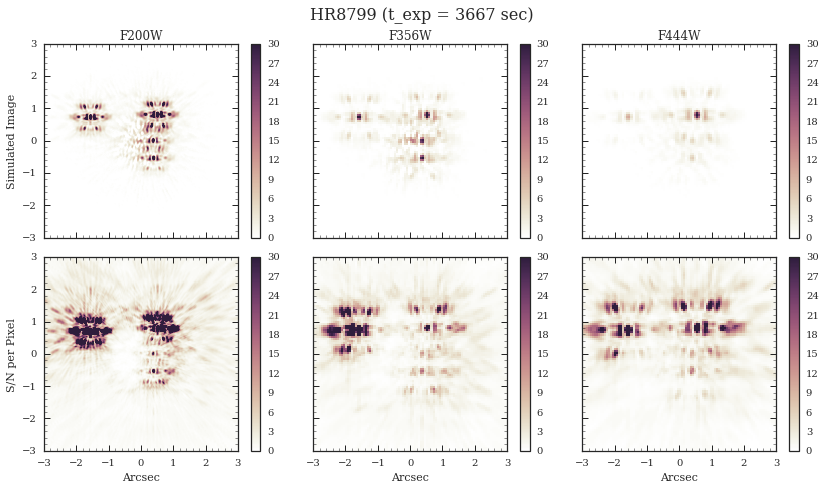

In [101]:
gen_images()

In [9]:
def do_all(save_fig=True):
    clear_output()
    
    print(source, dist, sptype, age, kmag)
    gen_obs()
    clear_output()
    
    print(source, dist, sptype, age, kmag)
    do_exp()
    gen_plots(save_fig=save_fig)

In [23]:
outdir  = '/Volumes/NIRData/'
for (source, dist, sptype, age, kmag) in args_sources:
    do_all()
    plt.close()

    clear_output()

HR8799 39.0 F0V 100 5.24
F356W_MASK335R_CIRCLYOT
New Ramp Settings:
  read_mode :    DEEP8
  nf        :        8
  nd2       :       12
  ngroup    :       10
  nint      :       18
New Detector Settings
  wind_mode :   WINDOW
  xpix      :      320
  ypix      :      320
  x0        :     1238
  y0        :     1502
New Ramp Times
  t_group   :   21.381
  t_frame   :    1.069
  t_int     :  200.980
  t_exp     : 3617.631
  t_acq     : 3636.874
Max Flux: 362.1 [348.4] counts/sec
Well Fill: 1.0 [0.9] times full well
SNR Max: 0.0

F444W_MASK335R_CIRCLYOT
Max Flux: 269.3 [245.1] counts/sec
Well Fill: 0.7 [0.7] times full well
SNR Max: 0.0



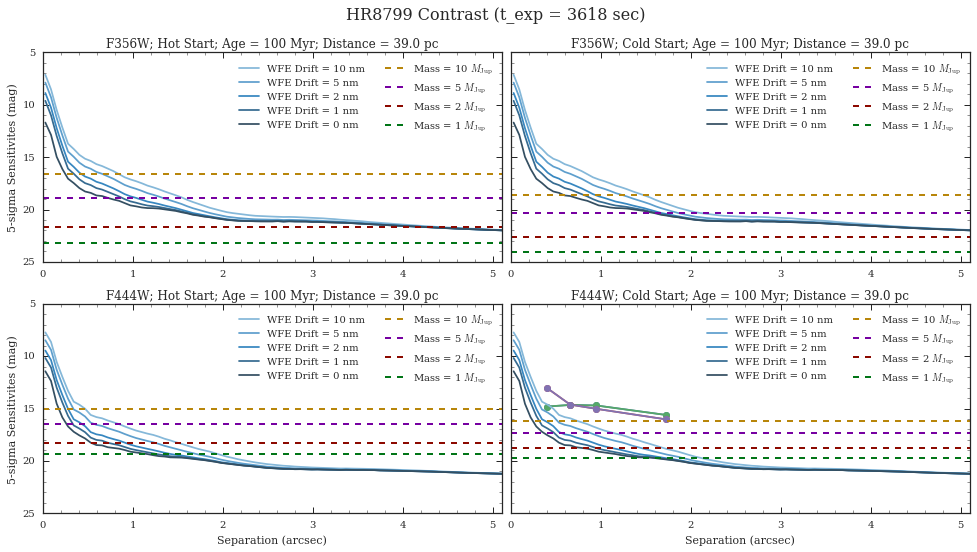

In [13]:
outdir  = '/Volumes/NIRData/'
(source, dist, sptype, age, kmag) = args_sources[0]
do_all()


In [32]:
temp = obs_dict[filt_keys[0]]
temp.sat_limits(sp=nrc_utils.stellar_spectrum('M3V'), verbose=True)

F356W Saturation Limit assuming M3V source: 5.51


{u'Spectrum': 'M3V',
 u'bp_lim': 'F356W',
 u'satmag': 5.514093424917042,
 u'units': u'vegamag'}